<h1 style="text-align:center;font-size:30px;font-weight:800"> Quora Question Pairs </h1>

## Description
<p>Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.</p>
<p>
Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
</p>
<br>

> Credits: Kaggle 


__Problem Statement__
- Identify which questions asked on Quora are duplicates of questions that have already been asked. 
- This could be useful to instantly provide answers to questions that have already been answered. 
- We are tasked with predicting whether a pair of questions are duplicates or not. 

<h2> Data Overview </h2>

<p> 
- Data will be in a file Train.csv <br>
- Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate <br>
- Size of Train.csv - 60MB <br>
- Number of rows in Train.csv = 404,290
</p>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from path import Path

## Reading data

In [2]:
path = Path('data')

In [3]:
df = pd.read_csv('./data/train.csv')
print(f"Records:: {df.shape}")
df.head()

Records:: (404290, 6)


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
df.describe()

,id,qid1,qid2,is_duplicate
count,404290.000000,404290.000000,404290.000000,404290.000000
mean,202144.500000,217243.942418,220955.655337,0.369198
std,116708.614502,157751.700002,159903.182629,0.482588
min,0.000000,1.000000,2.000000,0.000000
25%,101072.250000,74437.500000,74727.000000,0.000000
50%,202144.500000,192182.000000,197052.000000,0.000000
75%,303216.750000,346573.500000,354692.500000,1.000000
max,404289.000000,537932.000000,537933.000000,1.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


<h3> Distribution of data points among output classes</h3>
- Number of duplicate(smilar) and non-duplicate(non similar) questions

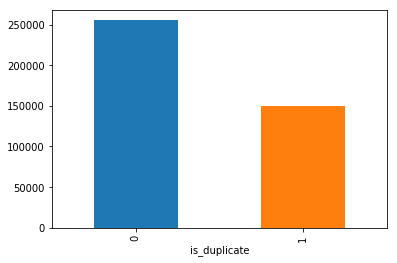

In [6]:
df.groupby('is_duplicate')['id'].count().plot.bar();

In [7]:
print(f'~> Total number of question pairs for training:\n   {len(df)}')

~> Total number of question pairs for training:
   404290


In [15]:
print(f'~> Question pair not similar:\n   {round((df[df.is_duplicate == 0]["id"].count() / len(df)) * 100, 2)}%')
print(f'~> Question pair similar:\n   {round((df[df.is_duplicate == 1]["id"].count() / len(df)) * 100, 2)}%')

~> Question pair not similar:
   63.08%
~> Question pair similar:
   36.92%


<h3> Number of unique questions </h3>

In [22]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qs = len(np.unique(qids))
repeated_qsn = np.sum(qids.value_counts() > 1)

print(f"Total number of unique questions are:: {unique_qs}")
print(f"Total number of repeated questions:: {repeated_qsn} ({round(repeated_qsn / unique_qs * 100, 2)})")


print (f"Max number of times a single question is repeated: {max(qids.value_counts())}\n") 

q_vals=qids.value_counts()

q_vals=q_vals.values

Total number of unique questions are:: 537933
Total number of repeated questions:: 111780 (20.78)
Max number of times a single question is repeated: 157



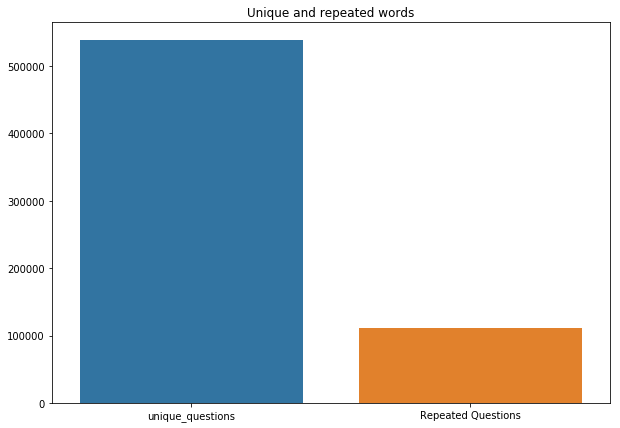

In [23]:
x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qs , repeated_qsn]

plt.figure(figsize=(10, 7))
plt.title("Unique and repeated words")
sns.barplot(x, y)
plt.show()

<h3> Checking for Duplicates </h3>

In [29]:
pair_duplicates = df[['qid1', 'qid2']].groupby(['qid1', 'qid2']).count().reset_index()
print(f"Total duplicated records:: {(pair_duplicates.shape[0] - df.shape[0])}")

Total duplicated records:: 0


<h3> Number of occurrences of each question </h3>

Maximum number of times a single question is repeated:: 157



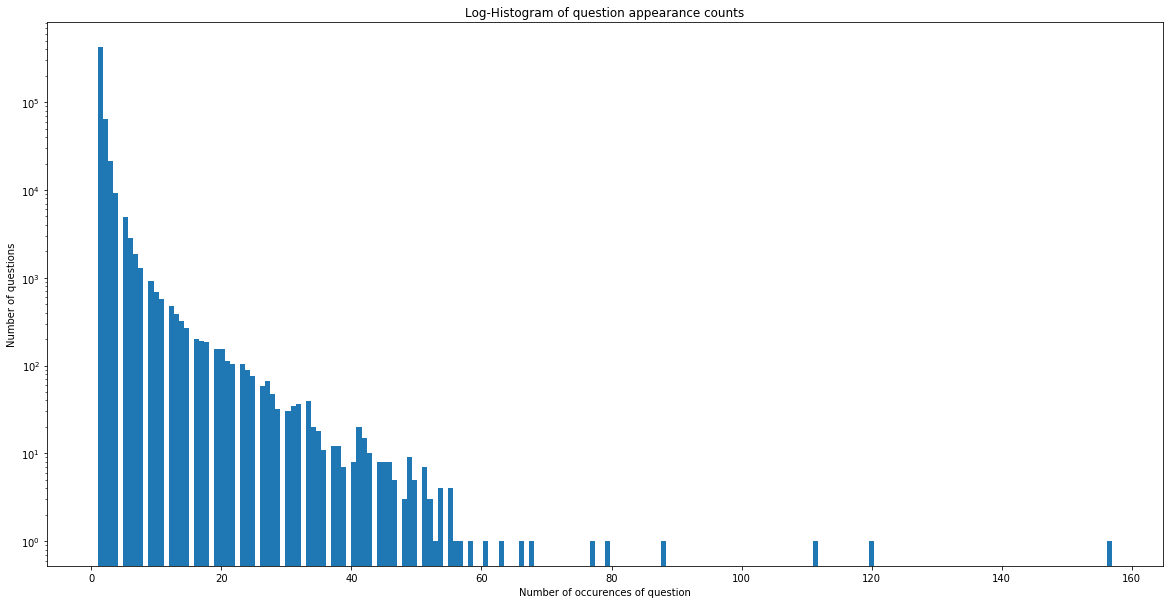

In [30]:
plt.figure(figsize=(20, 10))
plt.hist(qids.value_counts(), bins=200)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')

print (f'Maximum number of times a single question is repeated:: {max(qids.value_counts())}\n') 

<h3> Checking for NULL values </h3>

In [32]:
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0  


- There are two rows with null values in question2 

In [33]:
df = df.fillna('')
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


<h2> Basic Feature Extraction (before cleaning) </h2>

Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [38]:
df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count')
df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')

df['q1len'] = df['question1'].str.len()
df['q2len'] = df['question2'].str.len()


df['q1_n_words'] = df['question1'].apply(lambda x: len(x.split(" ")))
df['q2_n_words'] = df['question2'].apply(lambda x: len(x.split(" ")))


def normalized_common_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
    return 1.0 * len(w1 & w2)

def normalized_total_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
    return 1.0 * (len(w1) + len(w2))

def normalized_shared_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
    return 1.0 * len(w1 & w2) / (len(w1) + len(w2))


df['word_common'] = df.apply(normalized_common_words, axis=1)
df['word_total'] = df.apply(normalized_total_words, axis=1)
df['word_share'] = df.apply(normalized_shared_words, axis=1)


df['freq_q1+q2'] = df['freq_qid1'] + df['freq_qid2']
df['freq_q1-q2'] = abs(df['freq_qid1'] - df['freq_qid2'])

df.to_csv('df_fe_without_preprocessing_train.csv', index=False)

df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_common,word_total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


<h3> Analysis of some of the extracted features </h3>

- Here are some questions have only one single words.

In [41]:
print(f"Minimum length of questions in question1:: {min(df['q1_n_words'])}")
print(f"Minimum length of questions in question1:: {min(df['q2_n_words'])}")
      
      
print (f"Number of Questions with minimum length [question1]:: {df[df['q1_n_words']== min(df['q1_n_words'])].shape[0]}")
print (f"Number of Questions with minimum length [question2]:: {df[df['q2_n_words']== min(df['q1_n_words'])].shape[0]}")

Minimum length of questions in question1:: 1
Minimum length of questions in question1:: 1
Number of Questions with minimum length [question1]:: 67
Number of Questions with minimum length [question2]:: 24


<h4> Feature: word_share </h4>

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



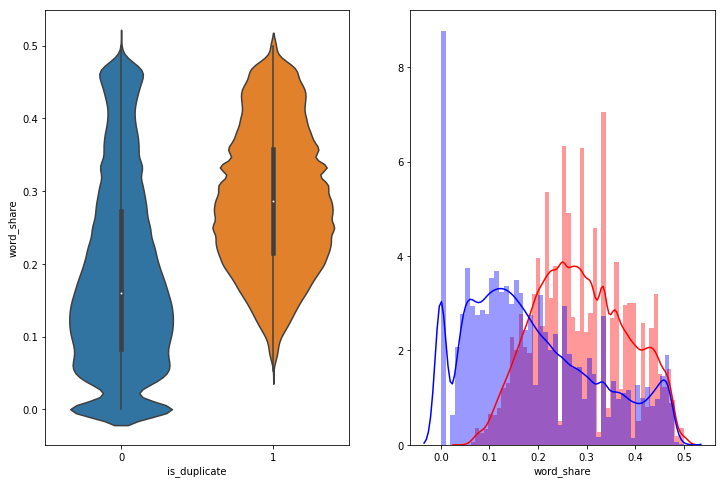

In [43]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)

sns.violinplot(x='is_duplicate', y='word_share', data=df[0:])

plt.subplot(1, 2, 2)
sns.distplot(df[df.is_duplicate == 1.0]['word_share'][0:], label='1', color='red')
sns.distplot(df[df.is_duplicate == 0.0]['word_share'][0:], label='0', color='blue')
plt.show()

- The distributions for normalized word_share have some overlap on the far right-hand side, i.e., there are quite a lot of questions with high word similarity
- The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar)

<h4> Feature: word_Common </h4>

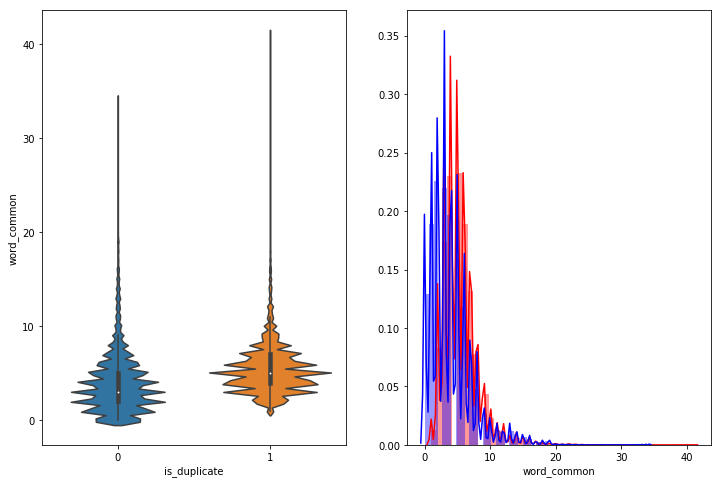

In [46]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_common', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_common'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_common'][0:] , label = "0" , color = 'blue' )
plt.show()